# Exercise Week 6, Lecture 12

In [1]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Load Data

In [2]:
data_file = '../Data/chl_data_stationX.txt'

In [3]:
df = pandas.read_table(data_file, delim_whitespace=True)
df.head()

,year,month,dd,y
0,2011,1,2011.08,0.10
1,2011,2,2011.15,0.17
2,2011,3,2011.23,0.21
3,2011,4,2011.31,0.19
4,2011,5,2011.38,0.11


## Date index

In [4]:
dates = []
for index, row in df.iterrows():
    dates.append(f'{int(row.year)}-{int(row.month)}')
dates = pandas.to_datetime(dates)
df['date'] = dates
df.set_index('date', inplace=True)
df.head()

,year,month,dd,y
date,,,,
2011-01-01,2011,1,2011.08,0.10
2011-02-01,2011,2,2011.15,0.17
2011-03-01,2011,3,2011.23,0.21
2011-04-01,2011,4,2011.31,0.19
2011-05-01,2011,5,2011.38,0.11


## Plot

<AxesSubplot:xlabel='date'>

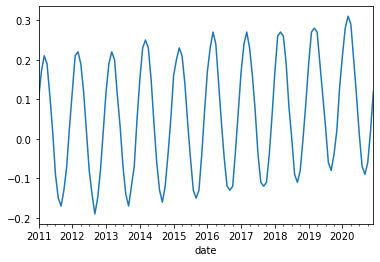

In [5]:
df.y.plot()

# 2. Linear trend with seasonal (via dummy)

## Add dummy variables

In [34]:
dummy = np.zeros((len(df), 11), dtype=int)
for i in np.arange(11):
    for j in np.arange(len(df)):
        if df.month.values[j] == i+1:
            dummy[j,i] = 1

In [36]:
dummies = []
for idum in np.arange(11):
    key = f'dum{idum}'
    dummies.append(key)
    df[key] = dummy[:,idum]

## Add time

In [38]:
time = np.arange(len(df)) + 1
df['time'] = time

## Fit

In [39]:
formula = "y ~ dum0 + dum1 + dum2 + dum3 + dum4 + dum5 + dum6 + dum7 + dum8 + dum9 + dum10 + time"
mod1 = smf.glm(formula=formula, data=df).fit()#, family=sm.families.Binomial()).fit()

In [51]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                            GLM   Df Residuals:                      107
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                      0.00014461
Method:                          IRLS   Log-Likelihood:                 367.10
Date:                Wed, 04 May 2022   Deviance:                     0.015473
Time:                        10:25:23   Pearson chi2:                   0.0155
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0092      0.004      2.122      0.034       0.001       0.018
dum0           0.0970      0.005     17.992      0.000       0.086       0.108
dum1           0.1681      0.005     31.195      0.000       0.157       0.179
dum2           0.1922      0.005     35.679      0.000       0.182       0.203
dum3           0.1692      0.005     31.436      0.000       0.159       0.180
dum4           0.0883      0.005     16.413      0.000       0.078       0.099
dum5          -0.0076      0.005     -1.406      0.160      -0.018       0.003
dum6          -0.1045      0.005    -19.418      0.000      -0.115      -0.094
dum7          -0.1794      0.005    -33.345      0.000      -0.190      -0.169
dum8          -0.2033      0.005    -37.794      0.000      -0.214      -0.193
dum9          -0.1732      0.005    -32.202      0.000      -0.184      -0.163
dum10         -0.1011      0.005    -18.798      0.000      -0.112      -0.091
time           0.0009   3.18e-05     28.438      0.000       0.001       0.001
==============================================================================
"""

In [52]:
mod1.aic

-708.1933546677249

# 3. Plot

<Figure size 432x288 with 0 Axes>

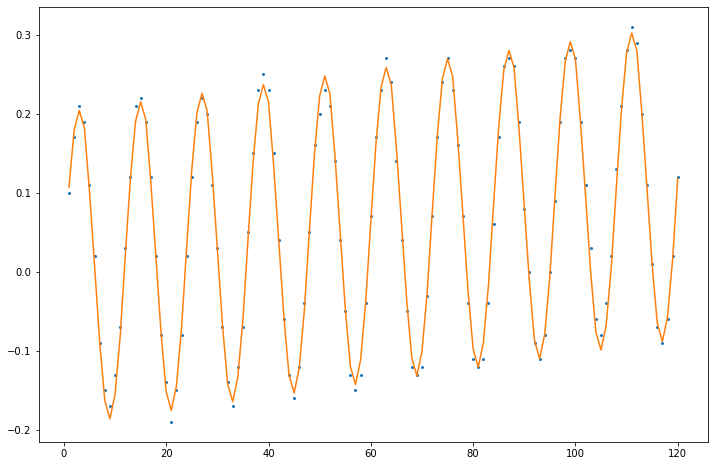

In [40]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(df['time'], df['y'], 'o', ms=2)
# Fit
ax.plot(df['time'], mod1.fittedvalues)
#
plt.show()

# 4. ACF of Residuals

In [41]:
y_resids = df.y.values - mod1.fittedvalues.values

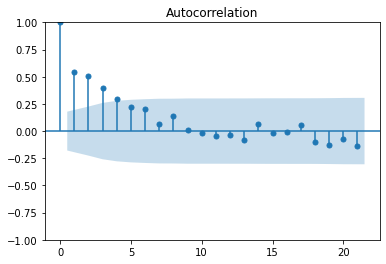

In [43]:
_ = plot_acf(y_resids)

/home/xavier/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


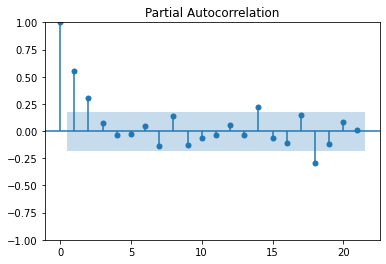

In [44]:
_ = plot_pacf(y_resids)

# 5.  Fit with p=1 GLS

In [48]:
exog = pandas.DataFrame()
exog['time'] = df.time
# Dummy
for idum in np.arange(11):
    key = f'dum{idum}'
    exog[key] = df[key]

In [49]:
glsar_model = sm.GLSAR(df.y, exog, 2)
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                                GLSAR Regression Results                               
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                          GLSAR   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              1531.
Date:                Wed, 04 May 2022   Prob (F-statistic):                   7.21e-113
Time:                        10:22:34   Log-Likelihood:                          357.90
No. Observations:                 118   AIC:                                     -691.8
Df Residuals:                     106   BIC:                                     -658.6
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# 6. Plot

<Figure size 432x288 with 0 Axes>

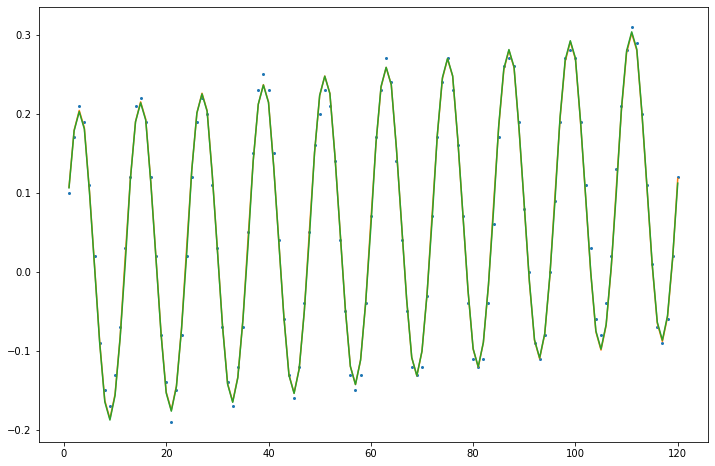

In [54]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(df['time'], df['y'], 'o', ms=2)
# Fits
ax.plot(df['time'], mod1.fittedvalues)
ax.plot(df['time'], glsar_results.fittedvalues)
#
plt.show()

# 7. Trend?

In [53]:
glsar_results.params

time     0.000934
dum0     0.105236
dum1     0.176524
dum2     0.199751
dum3     0.176816
dum4     0.095882
dum5    -0.000052
dum6    -0.096986
dum7    -0.171921
dum8    -0.195855
dum9    -0.165789
dum10   -0.093723
dtype: float64

----

# First example -- script_gls_W6_L12.R

## Load data

In [14]:
gls_data = pandas.read_table('example_gls_W6_L12.txt')
gls_data.head()

,d
0,-0.091690
1,-0.276385
2,-1.673630
3,-2.268807
4,-1.052491


<AxesSubplot:>

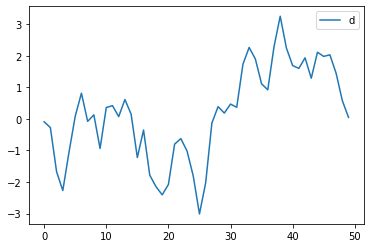

In [15]:
gls_data.plot()

## Fit with a line

In [16]:
gls_data['time'] = np.arange(len(gls_data))+1

In [19]:
formula = "d ~ time"
lm_model = smf.glm(formula=formula, data=gls_data).fit()#, family=sm.f
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      d   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.4803
Method:                          IRLS   Log-Likelihood:                -79.732
Date:                Wed, 04 May 2022   Deviance:                       71.052
Time:                        10:01:55   Pearson chi2:                     71.1
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4005
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3631      0.349     -3.902      0.000      -2.048      -0.678
time           0.0603      0.012      5.054      0.000       0.037       0.084
==============================================================================
"""

## Plot

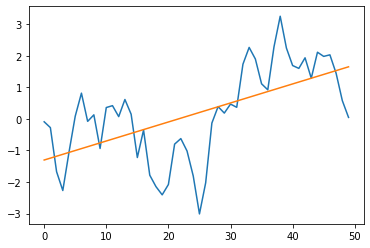

In [20]:
plt.clf()
ax=plt.gca()
ax.plot(gls_data.d)
ax.plot(lm_model.fittedvalues)
#

## Examine Residuals

In [23]:
gls_resids = gls_data.d.values - lm_model.fittedvalues.values

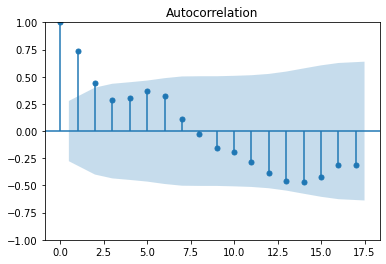

In [25]:
_ = plot_acf(gls_resids)

/home/xavier/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


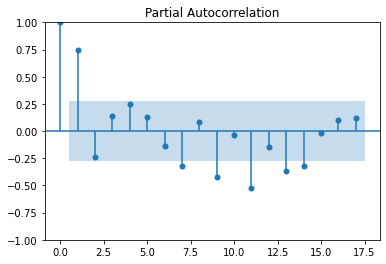

In [26]:
_ = plot_pacf(gls_resids)

## Fit AR(1)

In [46]:
tmp = pandas.DataFrame()
tmp['time'] = gls_data.time

In [47]:
glsar_model = sm.GLSAR(gls_data.d, tmp, 1)
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                                GLSAR Regression Results                               
Dep. Variable:                      d   R-squared (uncentered):                   0.152
Model:                          GLSAR   Adj. R-squared (uncentered):              0.134
Method:                 Least Squares   F-statistic:                              8.609
Date:                Wed, 04 May 2022   Prob (F-statistic):                     0.00512
Time:                        10:20:30   Log-Likelihood:                         -85.378
No. Observations:                  49   AIC:                                      172.8
Df Residuals:                      48   BIC:                                      174.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Plot

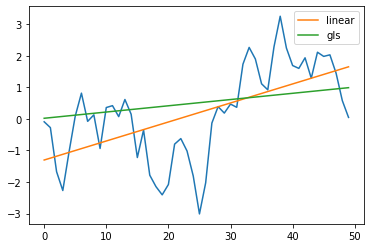

In [33]:
plt.clf()
ax=plt.gca()
ax.plot(gls_data.d)
ax.plot(lm_model.fittedvalues, label='linear')
ax.plot(glsar_results.fittedvalues, label='gls')
ax.legend()

----